<a href="https://colab.research.google.com/github/archivesunleashed/notebooks/blob/master/parquet_pandas_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working with Archives Unleashed Parquet Derivatives

In this notebook, we'll setup an environment, then download a dataset of web archive collection derivatives that were produced with the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). These derivatives are in the [Apache Parquet](https://parquet.apache.org/) format, which is a [columnar storage](http://en.wikipedia.org/wiki/Column-oriented_DBMS) format. These derivatives are generally small enough to work with on your local machine, and can be easily converted to Pandas DataFrames as demonstrated below.

This notebook is useful for exploring the following derivatives. 

**[Binary Analysis](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#binary-analysis)**
- [Audio](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-audio-information)
- [Images](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-image-information)
- [PDFs](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-pdf-information)
- [Presentation program files](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-presentation-program-files-information)
- [Spreadsheets](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-spreadsheet-information)
- [Text files](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-text-files-information)
- [Videos](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-video-information)
- [Word processor files](https://github.com/archivesunleashed/aut-docs/blob/master/current/binary-analysis.md#extract-word-processor-files-information)

**Web Pages**

`.webpages().select($"crawl_date", $"url", $"mime_type_web_server", $"mime_type_tika", RemoveHTMLDF(RemoveHTTPHeaderDF(($"content"))).alias("content"))` 

Produces a DataFrame with the following columns:
  - `crawl_date`
  - `url`
  - `mime_type_web_server`
  - `mime_type_tika`
  - `content`

As the `webpages` derivative is especially rich - it contains the full text of all webpages - we have a separate notebook for [text analysis](https://github.com/archivesunleashed/notebooks/blob/master/parquet_text_analyis.ipynb) here.

**Web Graph**

`.webgraph()` 

Produces a DataFrame with the following columns:
  - `crawl_date`
  - `src`
  - `dest`
  - `anchor`

**Image Links**

`.imageLinks()`

Produces a DataFrame with the following columns:
  - `src`
  - `image_url`

**Domains**

`.webpages().groupBy(ExtractDomainDF($"url").alias("url")).count().sort($"count".desc)`

Produces a DataFrame with the following columns:
- domain
- count

We recommend running through the notebook with the provided sample dataset. You may then want to substitute it with your own dataset.

# Dataset

First, we will need a web archive dataset to work with.

In this example notebook we use a dataset from [Bibliothèque et Archives nationales du Québec](https://www.banq.qc.ca/accueil/). It is a web archive collection of the Ministry of Environment of Québec (2011-2014), that has been  processed by the [Archives Unleashed Toolkit](https://github.com/archivesunleashed/aut/). Merci beaucoup BAnQ!

[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3605525.svg)](https://doi.org/10.5281/zenodo.3605525)

Curious about the size the derivative Parquet output compared to the size of the web archive collection?

The total size of all 12 Parquet deriatives is 594M, with `webpages` being the largest (528M) since it has a column with full text (`content`).

```
2.5M	./videos
344K	./domains
1.7M	./word-processor-files
24K	./presentation-program-files
1.7M	./spreadsheets
880K	./audio
4.4M	./images
528M	./webpages
1.7M	./text-files
3.9M	./pdfs
29M	./webgraph
22M	./imagelinks
594M	.
```

The total size of the web archive collection is 165G. The derivative file is thus a 99.68% decrease!

The following command downloads all of the parquets file from the Zenodo data repository. To run a 'cell,' you can click the play button next to the cell or you can press your shift key and enter key at the same time.

Whenever you see code snippets like this, you should do the same thing to run it.


In [0]:
%%capture

!curl -L "https://zenodo.org/record/3598450/files/environnement-qc.tar.gz?download=1" > environment-qc-parquet.tar.gz
!tar -xzf environment-qc-parquet.tar.gz

The following command provides a list of all the downloaded parquet files. You should see a list of all the different derivatives here - note that they line up with the list provided at the beginning of this notebook.


In [2]:
!ls -1 parquet

audio
domains
imagelinks
images
pdfs
presentation-program-files
spreadsheets
text-files
videos
webgraph
webpages
word-processor-files


# Environment

Next, we'll setup our environment so we can work with the Parquet output with [Pandas](https://pandas.pydata.org).

In [0]:
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt

# Loading our Archives Unleashed Datasets as DataFrames

Next, we'll load up our datasets to work with and show a preview of each. We'll load the network, domains, web graph, and images. 

The remainder of the binary datasets (audio, video, spreadsheets, etc.) will all follow the same pattern as the images dataset, except that they do not have the height and width columns. A useful exercise when trying to learn how to use this would be to swap out images for audio, for example, and see how you can explore these other file types.

We've provided a [separate notebook](https://github.com/archivesunleashed/notebooks/blob/master/parquet_text_analyis.ipynb) to work with the pages dataset  because it tends to be resource intensive.


## Images

The following commands create a variable called `images` that contain a DataFrame with all of the image information from the web archive. 

**Reminder:** If you want to look at a differnt derivative, you can, for instance, replace out `images` for `audio`.

In [4]:
images_parquet = pq.read_table('parquet/images')
images = images_parquet.to_pandas()
images

,url,filename,extension,mime_type_web_server,mime_type_tika,width,height,md5
0,http://www.mddelcc.gouv.qc.ca/pesticides/jardi...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
1,http://www.mddep.gouv.qc.ca//pesticides/jardin...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
2,http://www.mddefp.gouv.qc.ca/pesticides/jardin...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
3,http://www.mddefp.gouv.qc.ca////pesticides/jar...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
4,http://www.mddefp.gouv.qc.ca////pesticides/jar...,mille-clop-carabe.jpg,jpg,image/jpeg,image/jpeg,151,150,fff9b162031400d2dc96ec30284f580e
...,...,...,...,...,...,...,...,...
156161,http://mddep.gouv.qc.ca///biodiversite/habitat...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
156162,http://mddep.gouv.qc.ca//biodiversite/habitats...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
156163,http://www.mddep.gouv.qc.ca/biodiversite/habit...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8
156164,http://mddep.gouv.qc.ca////biodiversite/habita...,image-ile-G.jpg,jpg,image/jpeg,image/jpeg,375,500,000175bcfb5be374c5f8da05bfe49dc8


## Web Graph

The next data that we will explore will be the "web graph." This is a DataFrame containing all the hyperlinks within a collection - from `src` (or the page that _contains_ the link) to `dest` (or the page that the link is linking _to_). It also includes the date when this link was crawled, as well as the `anchor` text (what the user clicks on to visit).

In [5]:
webgraph_parquet = pq.read_table('parquet/webgraph')
webgraph = webgraph_parquet.to_pandas()
webgraph

,crawl_date,src,dest,anchor
0,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communiq...,http://www.mddefp.gouv.qc.ca/changements/carbo...,modification r�glementaire
1,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communiq...,http://recherched.gouv.qc.ca/internet/search.d...,Recherche
2,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communiq...,http://www.gouv.qc.ca/,
3,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communiq...,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2002"
4,20121218,http://www.vehiculeselectriques.gouv.qc.ca/eng...,http://www.gouv.qc.ca/portail/quebec/pgs/commu...,Québec Portal
...,...,...,...,...
1439507,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat...,http://www.gouv.qc.ca/,
1439508,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat...,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2002"
1439509,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat...,http://recherched.gouv.qc.ca/internet/search.d...,Recherche
1439510,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat...,http://www.gouv.qc.ca/,


## Domains

This derivative contains basic information about what's been collected in the crawl. Specifically we can analyze how often pages from each domain appear.

In [6]:
domains_parquet = pq.read_table('parquet/domains')
domains = domains_parquet.to_pandas()
domains

,url,count
0,www.mddefp.gouv.qc.ca,108409
1,www.mddep.gouv.qc.ca,99854
2,www.mddelcc.gouv.qc.ca,83594
3,mddep.gouv.qc.ca,47392
4,mddefp.gouv.qc.ca,39783
...,...,...
76,www.mnba.qc.ca,1
77,www.cbd.int,1
78,s7.addthis.com,1
79,www.longtailvideo.com,1


# Data Analysis

Now that we have all of our datasets loaded up, we can begin to work with them!

## Counting total files, and unique files



#### Count number of rows (how many images are in the web archive collection).


In [7]:
images.count()

url                     156166
filename                156166
extension               156166
mime_type_web_server    156166
mime_type_tika          156166
width                   156166
height                  156166
md5                     156166
dtype: int64

 #### How many unique images are in the collection?

 We can see if an image is unique or not by computing an [MD5 hash](https://en.wikipedia.org/wiki/MD5#MD5_hashes) of it. The exact same image might be called `example.jpg` and `foo.jpg` - by computing the hash, we can see that even with different file names, they are actually the same image!




In [8]:
len(images.md5.unique())

18287

#### What are the top 10 most occurring images in the collection?

Here we discover which image (or images) occur most frequently. 

In [9]:
images['md5'].value_counts().head(10)

b09dc3225d5e1377c52c06feddc33bfe    192
e7d1f7750c16bc835bf1cfe1bf322d46    192
a4d3ddfb1a95e87650c624660d67765a    192
5283d313972a24f0e71c47ae3c99958b    192
89663337857f6d769fbcaed7278cc925     77
497db34fffa0e278f57ae614b4b758a0     64
58e5d8676dfcc4205551314d98fb2624     61
100322cfd242ee75dd5a744526f08d6b     56
65274f9eaa4c585b7c35193ebb04e0d7     53
838f6da6f67b96e0750570630056c31d     53
Name: md5, dtype: int64


#### What's the information around all of the occurances of `b09dc3225d5e1377c52c06feddc33bfe`?

What, you mean you don't know what `b09dc3225d5e1377c52c06feddc33bfe` means? Let's find those images in the DataFrame table - we can here see the real file name (`erosion.jpg`) and more importantly, its URL within the web archive.


In [10]:
images.loc[images['md5'] == 'b09dc3225d5e1377c52c06feddc33bfe']

,url,filename,extension,mime_type_web_server,mime_type_tika,width,height,md5
46963,http://www.mddefp.gouv.qc.ca//poissons/st-char...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
46964,http://www.mddep.gouv.qc.ca/poissons/yamaska/e...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
46965,http://mddefp.gouv.qc.ca/poissons/st-maurice/e...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
46966,http://mddefp.gouv.qc.ca/poissons/st-francois/...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
46967,http://mddefp.gouv.qc.ca/poissons/chateauguay/...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
...,...,...,...,...,...,...,...,...
47150,http://www.mddelcc.gouv.qc.ca//poissons/yamask...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
47151,http://www.mddelcc.gouv.qc.ca//poissons/assomp...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
47152,http://www.mddelcc.gouv.qc.ca//poissons/st-fra...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe
47153,http://www.mddep.gouv.qc.ca/poissons/st-franco...,erosion.jpg,jpg,image/jpeg,image/jpeg,310,220,b09dc3225d5e1377c52c06feddc33bfe


### What does `b09dc3225d5e1377c52c06feddc33bfe` look like?

We can extract the binary from the web archive using our [binary extraction functions](https://github.com/archivesunleashed/aut-docs-new/blob/master/current/image-analysis.md#scala-df).

```scala
import io.archivesunleashed._
import io.archivesunleashed.df._

val df = RecordLoader
  .loadArchives("example.arc.gz", sc)
  .extractImageDetailsDF();

df.select($"bytes", $"extension")
  .saveToDisk("bytes", "/path/to/export/directory/your-preferred-filename-prefix", $"extension")
```

**But**, since we don't have access to the WARC files here, just the Parquet derivatives, we can make do  by trying to display a live web version of the image or a replay URL. In this case, BANQ's replay service is available at [https://waext.banq.qc.ca](https://waext.banq.qc.ca).

In [11]:
pd.options.display.max_colwidth = -1
one_image = images.loc[images['md5'] == 'b09dc3225d5e1377c52c06feddc33bfe'].head(1)
one_image['url']

46963    http://www.mddefp.gouv.qc.ca//poissons/st-charles/erosion.jpg
Name: url, dtype: object

![fish](https://waext.banq.qc.ca/wayback/20121127103149/http://www.mddefp.gouv.qc.ca/poissons/st-charles/erosion.jpg)

Unfortunately, while we can tell you this is such a popular image within the web archive, we can't tell you _why_. That's where the researcher comes in!

#### What are the top 10 most occuring filenames in the collection?

Note that this is of course different than the MD5 results up above. Here we are focusing _just_ on filename. So `carte-p.jpg` for example, might actually be referring to different images who happen to have the same name.


In [12]:
top_filenames = images['filename'].value_counts().head(10)
top_filenames

carte-p.jpg      1196
carte2.jpg       924 
carte1.jpg       875 
carte-g.jpg      660 
carte.jpg        576 
carte-an.jpg     575 
carte-qc.jpg     575 
carte-G.jpg      484 
carte_p.jpg      473 
carte_web.jpg    431 
Name: filename, dtype: int64

#### Let's plot it!

Text(0, 0.5, 'Count')

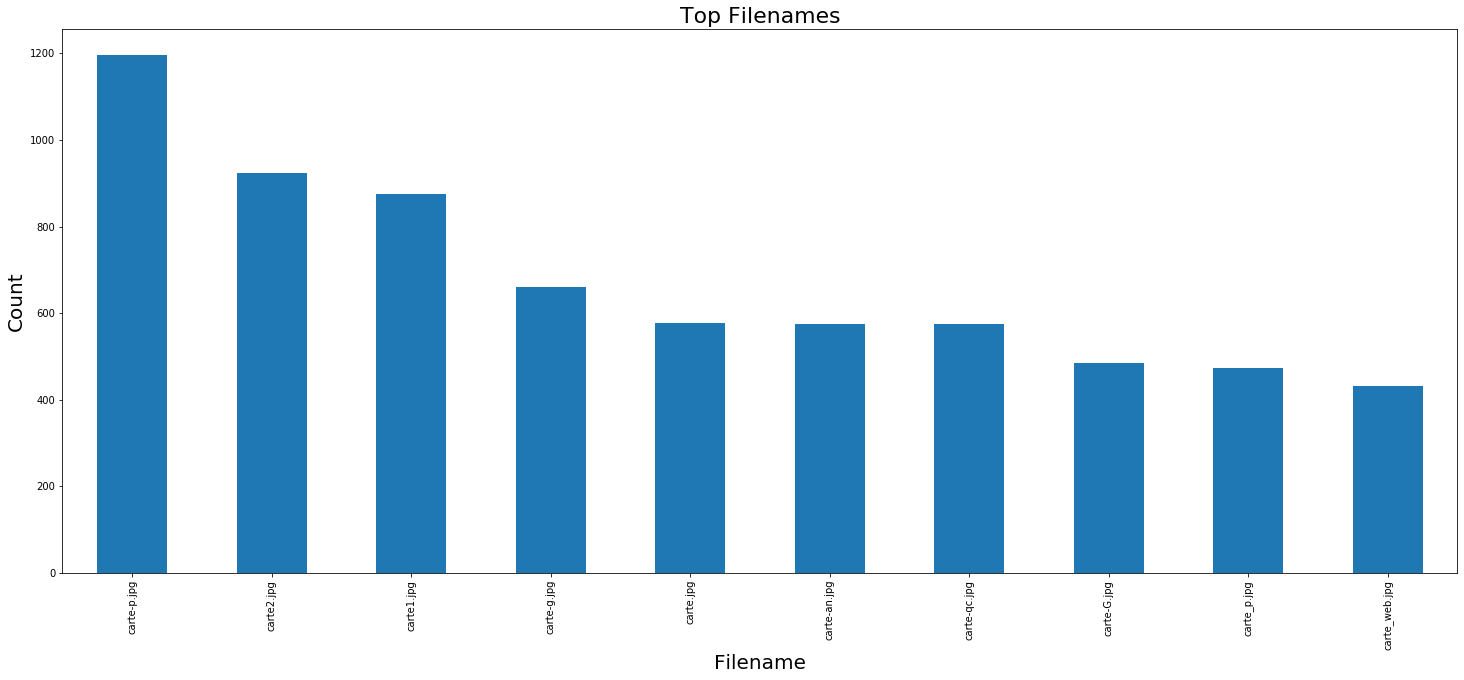

In [13]:
top_filenames_chart = top_filenames.plot.bar(figsize=(25,10))
top_filenames_chart.set_title("Top Filenames", fontsize=22)
top_filenames_chart.set_xlabel("Filename", fontsize=20)
top_filenames_chart.set_ylabel("Count", fontsize=20)

#### How about a MIME type distribution?

What _kind_ of image files are present? We can discover this by checking their "media type", or [MIME type](https://en.wikipedia.org/wiki/Media_type). 






Text(0, 0.5, 'Count')

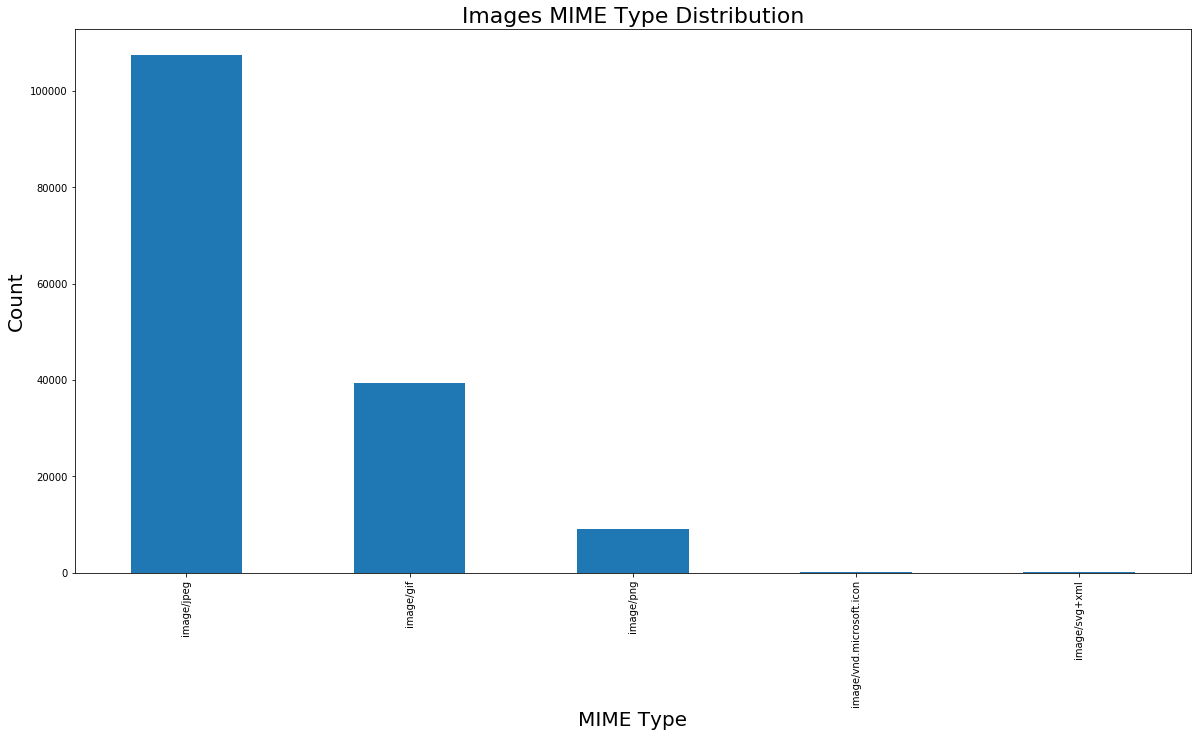

In [14]:
image_mime_types = images['mime_type_tika'].value_counts().head(5)
image_mime_type_chart = image_mime_types.plot.bar(figsize=(20,10))
image_mime_type_chart.set_title("Images MIME Type Distribution", fontsize=22)
image_mime_type_chart.set_xlabel("MIME Type", fontsize=20)
image_mime_type_chart.set_ylabel("Count", fontsize=20)

#### How about the distribution of the top 10 domains?

Here we can see which domains are the most frequent within the web archive.

Text(0, 0.5, 'Count')

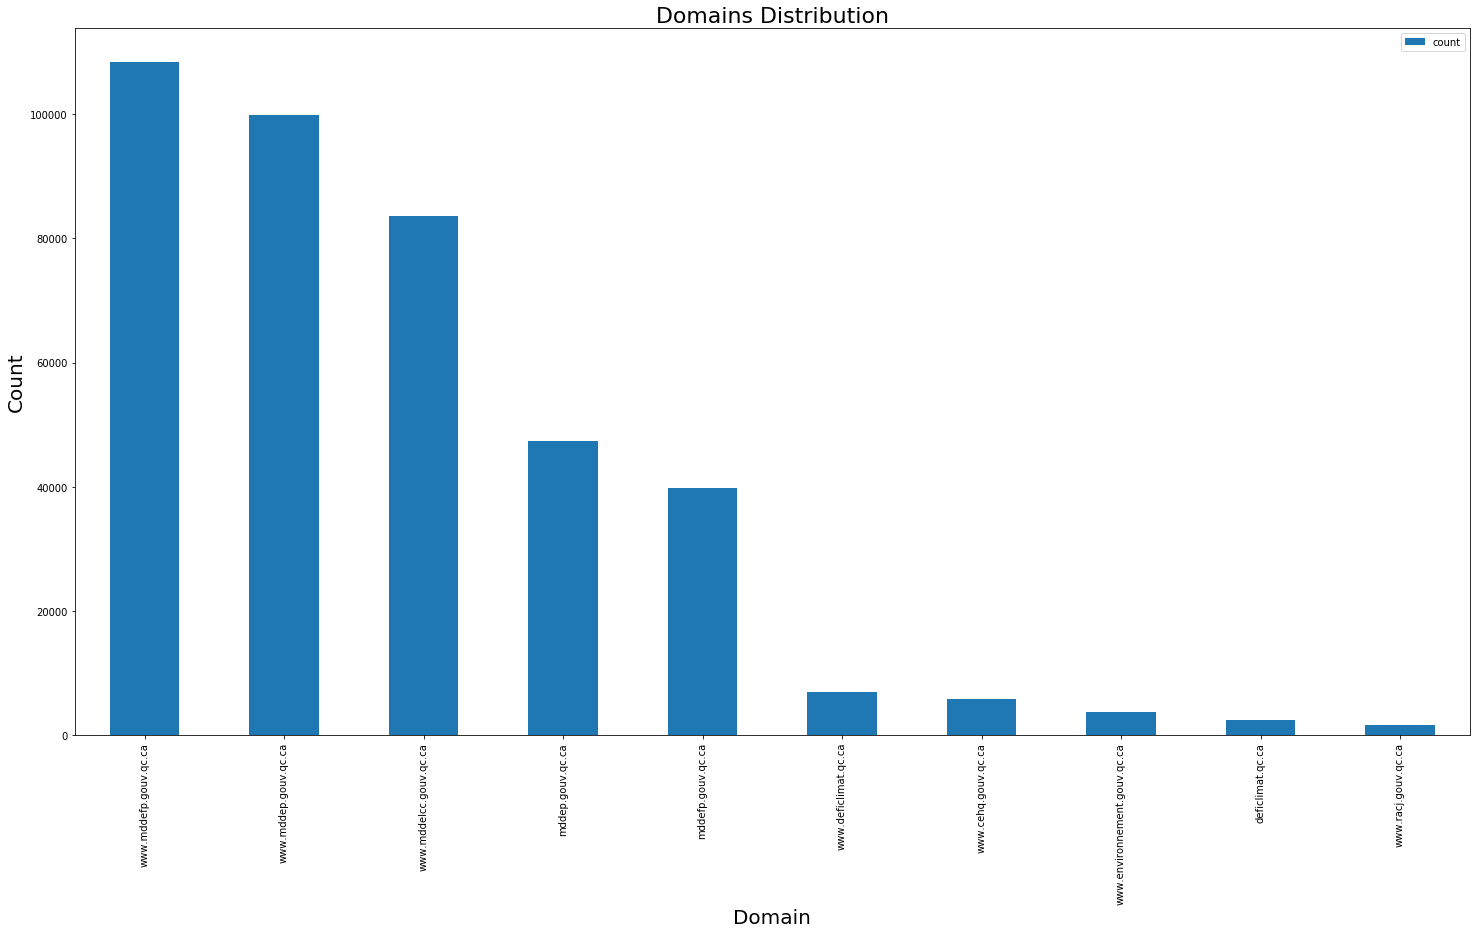

In [19]:
top_domains = domains.sort_values('count', ascending=False).head(10)
top_domains_chart = top_domains.plot.bar(x='url', y='count', figsize=(25,13))
top_domains_chart.set_title("Domains Distribution", fontsize=22)
top_domains_chart.set_xlabel("Domain", fontsize=20)
top_domains_chart.set_ylabel("Count", fontsize=20)

### Top Level Domain Analysis
Now let's create a new column, `tld`, which is based off an existing column, 'Domain'. This example should give you an idea of how you can expand these datasets to do further research and analysis. 

A [top-level domain](https://en.wikipedia.org/wiki/Top-level_domain) refers to the highest domain in an address - i.e. `.ca`, `.com`, `.org`, or yes, even `.pizza`.

Things get a bit complicated, however, in some national TLDs. While `qc.ca` (the domain for Quebec) isn't really a top-level domain, it has many of the features of one as people can directly register under it. Below, we'll use the command `suffix` to include this. 

> You can learn more about suffixes at https://publicsuffix.org.

We'll take the `Domain` column and extract the `tld` from it with [`tldextract`](https://github.com/john-kurkowski/tldextract).

First we'll add the [`tldextract`](https://github.com/john-kurkowski/tldextract) library to the notebook. Then, we'll create the new column.

In [0]:
%%capture

!pip install tldextract

In [17]:
import tldextract

domains['tld'] = domains.apply(lambda row: tldextract.extract(row.url).suffix, axis=1)
domains

,url,count,tld
0,www.mddefp.gouv.qc.ca,108409,qc.ca
1,www.mddep.gouv.qc.ca,99854,qc.ca
2,www.mddelcc.gouv.qc.ca,83594,qc.ca
3,mddep.gouv.qc.ca,47392,qc.ca
4,mddefp.gouv.qc.ca,39783,qc.ca
...,...,...,...
76,www.mnba.qc.ca,1,qc.ca
77,www.cbd.int,1,int
78,s7.addthis.com,1,com
79,www.longtailvideo.com,1,com


#### Next, let's count the distict TLDs.


In [20]:
tld_count = domains['tld'].value_counts()
tld_count

qc.ca    44
com      22
ca       5 
net      4 
gc.ca    3 
org      2 
int      1 
Name: tld, dtype: int64

#### Next, we'll plot the TLD count.


Text(0.5, 1.0, 'Top Level Domain Distribution')

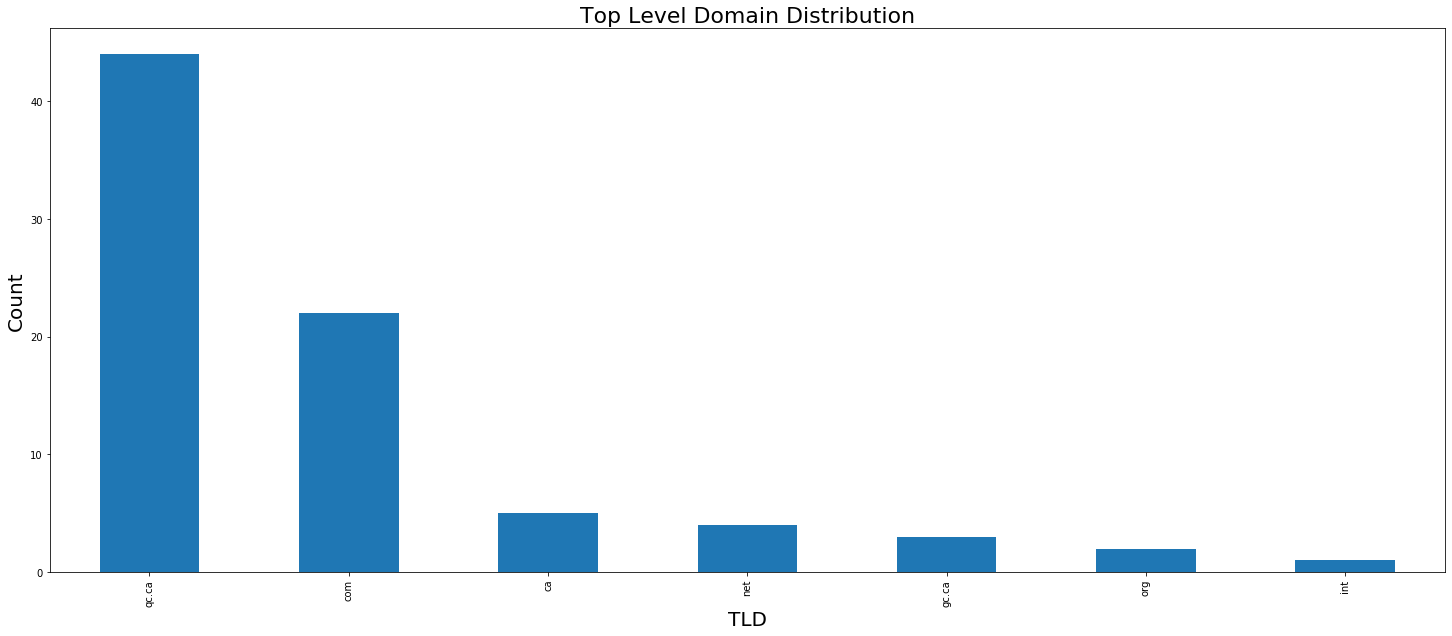

In [21]:
tld_chart = tld_count.plot.bar(legend=None, figsize=(25,10))
tld_chart.set_xlabel("TLD", fontsize=20)
tld_chart.set_ylabel("Count", fontsize=20)
tld_chart.set_title("Top Level Domain Distribution", fontsize=22)

## Examining the Web Graph

Remember the hyperlink web graph? Let's look at the web graph columns again.



In [22]:
webgraph

,crawl_date,src,dest,anchor
0,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communique.asp?no=2301,http://www.mddefp.gouv.qc.ca/changements/carbone/reg-mod-reg-spede.pdf,modification r�glementaire
1,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communique.asp?no=2301,http://recherched.gouv.qc.ca/internet/search.do?query=&searchIn=menv&charSet=ISO-8859-1&includesDir=http://www.mddefp.gouv.qc.ca/recherche/&includesExt=asp&displayLang=fr&searchLang=fr&source=IQA&hitsPerPage=10&leftMenu=false&template=default&pageWidth=760px&horizontalAlign=center&headerHeight=140px&bottomHeight=60px&leftMenuWidth=0px &dev=true,Recherche
2,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communique.asp?no=2301,http://www.gouv.qc.ca/,
3,20121218,http://www.mddefp.gouv.qc.ca/infuseur/communique.asp?no=2301,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2002"
4,20121218,http://www.vehiculeselectriques.gouv.qc.ca/english/nous-joindre.asp,http://www.gouv.qc.ca/portail/quebec/pgs/commun/?lang=fr,Québec Portal
...,...,...,...,...
1439507,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat.asp?site=090380001&methode=c,http://www.gouv.qc.ca/,
1439508,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat.asp?site=090380001&methode=c,http://www.droitauteur.gouv.qc.ca/copyright.php,"� Gouvernement du Qu�bec, 2002"
1439509,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat.asp?site=090500006,http://recherched.gouv.qc.ca/internet/search.do?query=&searchIn=menv&charSet=ISO-8859-1&includesDir=http://www.mddefp.gouv.qc.ca/recherche/&includesExt=asp&displayLang=fr&searchLang=fr&source=IQA&hitsPerPage=10&leftMenu=false&template=default&pageWidth=760px&horizontalAlign=center&headerHeight=140px&bottomHeight=60px&leftMenuWidth=0px &dev=true,Recherche
1439510,20121219,http://www.mddep.gouv.qc.ca/eau/guide/resultat.asp?site=090500006,http://www.gouv.qc.ca/,


### What are the most frequent crawl dates?


Text(0.5, 1.0, 'Crawl Date Frequency')

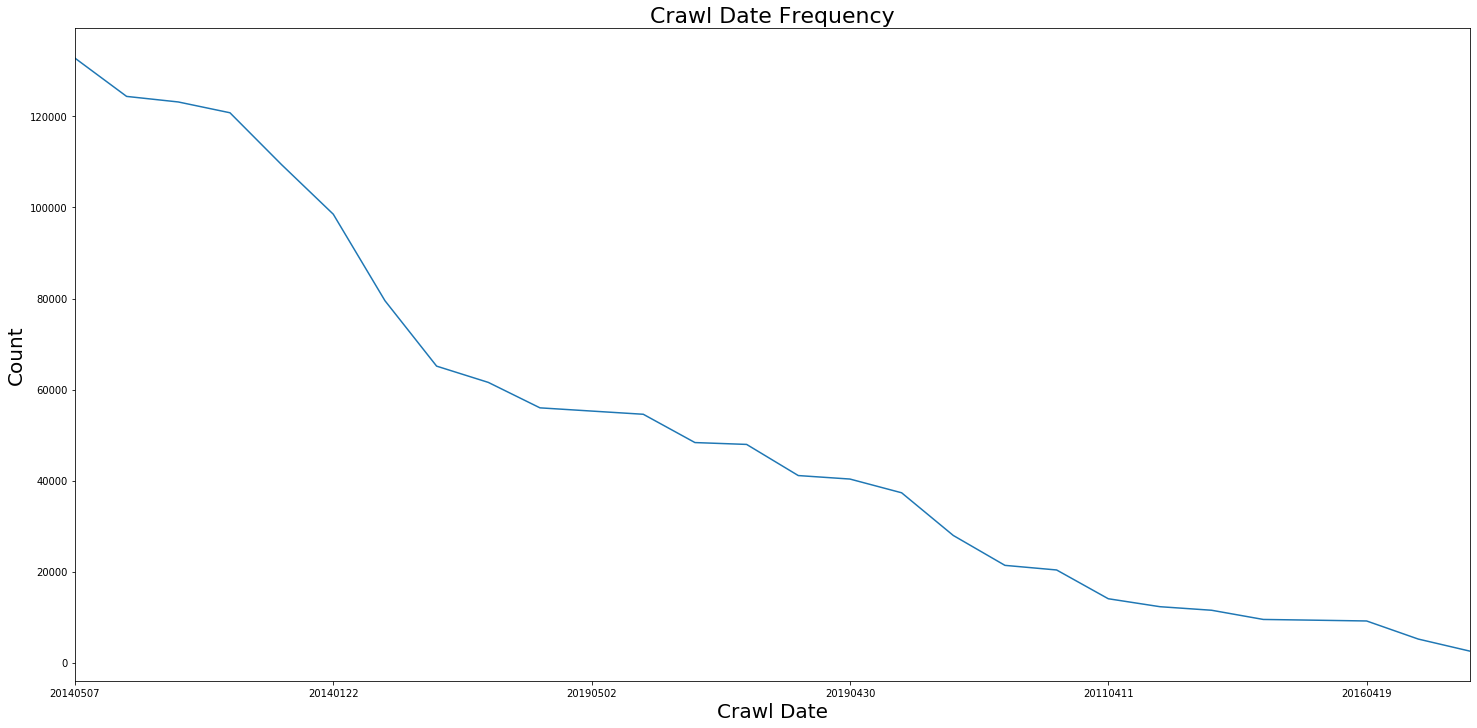

In [23]:
crawl_dates = webgraph['crawl_date'].value_counts()
crawl_dates
crawl_dates_chart = crawl_dates.plot.line(figsize=(25,12))
crawl_dates_chart.set_xlabel("Crawl Date", fontsize=20)
crawl_dates_chart.set_ylabel("Count", fontsize=20)
crawl_dates_chart.set_title("Crawl Date Frequency", fontsize=22)
